In [497]:
#%matplotlib notebook
import numpy as np
from scipy.signal import decimate
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.interpolate import interp1d
from scipy.signal import resample

In [987]:
# working version detection

class AutoTune():
    
    def __init__(self, wav, sensitivity=.02):
        
        
        assert len(wav) > 8*220
        
        # original audio
        self.wav = np.array(wav)
        
        # 1/8 decimation
        self.down_wav = decimate(self.wav, q=8)
        print(self.down_wav.shape)
        # declare tables
        self.Ei_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.Hi_Table = np.zeros((len(self.down_wav), 111), dtype=float)
        self.subTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.truTable = np.zeros((len(self.down_wav), 111), dtype=float)
        self.real_freq = np.zeros(len(self.wav), dtype=float)
        
        self.idxTable = []
        
        # first value of e table
        for L in range(2,111):
            self.Ei_Table[220,L] = sum(np.square(self.down_wav[221-2*L:221]))
            self.Hi_Table[220,L] = sum(np.multiply(self.down_wav[221-2*L:221-L], self.down_wav[221-L:221]))

        # loop to initialize tables
        for i in range(221, len(self.down_wav)):
            indx = []
            
            for L in range(2,111):
                self.Ei_Table[i, L] = self.Ei_Table[i-1, L] + self.down_wav[i]**2 - self.down_wav[i-2*L]**2
                self.Hi_Table[i, L] = self.Hi_Table[i-1, L] + self.down_wav[i]*self.down_wav[i-L] - self.down_wav[i-L]*self.down_wav[i-2*L]
                self.subTable[i, L] = self.Ei_Table[i, L] - 2*self.Hi_Table[i, L]
                

                #self.truTable[i, L] = self.subTable[i, L]<0.03*A.Ei_Table[i, L]
                if self.subTable[i, L] < sensitivity*self.Ei_Table[i, L] and L > 10 and L < 70:
                    value, freq = self.get_real_freq(i, L)
                    self.real_freq[i*8:(i+1)*8] = freq
                    if not i % 1000:
                        print('i:',i,'bigL:',8*L,'freq:',freq)
                    break
                    
                if L == 110:
                    self.real_freq[i*8:(i+1)*8] = self.real_freq[i*8-1]
                    
            
            # append successes to index list
            #self.idxTable.append(indx)
            
            
           
    def get_real_freq(self, down_indx, down_f_est):

        
        # convert to real signal indecies
        real_indx = 8*down_indx
        real_f_est = 8*down_f_est

        # create Ls index to calculate E and H for
        real_line = np.linspace(real_f_est-9,real_f_est+9,19, dtype=int)
        real_mins = np.zeros(len(real_line), dtype=float)

        for L in real_line:
            a = np.array(self.wav[real_indx-2*L+1:real_indx-L+1], dtype=np.float64)
            b = np.array(self.wav[real_indx-L+1:real_indx+1], dtype=np.float64)
            #print('E: ', self.wav[real_indx-2*L+1:real_indx+1])
            #print('H: ',self.wav[real_indx-2*L+1:real_indx-L+1],self.wav[real_indx-L+1:real_indx+1] )
            E = np.sum(np.square(a)) + np.sum(np.square(b))
            H = sum(a*b)
            
            val = (E-2*H)/E
            real_mins[L-real_line[0]] = val
        
        interpolation_line = np.linspace(real_line[0],real_line[-1],100, endpoint=True)
        int_obj = interp1d(real_line, real_mins, kind='cubic')
        interpolated = int_obj(interpolation_line)
        final_lag = interpolation_line[np.argmin(interpolated)]
        value = np.min(interpolated)

        return(value, (1/(final_lag/44100)))


        

In [978]:
A.real_freq[21000]

0.0

In [1137]:
# synthetic
freq = 250
data = (5*np.sin(np.arange(50000,dtype=float)*2*freq*np.pi/(44100.0)))+150

fs, data = wavfile.read('blal.wav')
#data=data[:,0]
#data=data[100000:200000]
#print(data[:50])
data.shape

(269248,)

In [1146]:
A = AutoTune(data, sensitivity=.02)
A.subTable.shape

(33656,)
i: 6000 bigL: 424 freq: 101.84757505773672
i: 7000 bigL: 440 freq: 100.87336244541484
i: 9000 bigL: 432 freq: 103.76470588235294
i: 10000 bigL: 440 freq: 100.45558086560365
i: 11000 bigL: 456 freq: 98.65771812080537
i: 12000 bigL: 480 freq: 93.63057324840764
i: 13000 bigL: 424 freq: 104.43487621097955
i: 14000 bigL: 424 freq: 102.88441145281017
i: 16000 bigL: 416 freq: 106.03278688524588
i: 17000 bigL: 424 freq: 104.30015050526768
i: 18000 bigL: 424 freq: 103.80911619944362
i: 19000 bigL: 432 freq: 104.25531914893617
i: 21000 bigL: 424 freq: 105.52534261474874
i: 24000 bigL: 408 freq: 108.35380835380835
i: 25000 bigL: 424 freq: 104.30015050526768
i: 26000 bigL: 416 freq: 105.98645400917631
i: 27000 bigL: 416 freq: 105.57127312295974
i: 28000 bigL: 400 freq: 107.82396088019561
i: 29000 bigL: 400 freq: 107.82396088019561
i: 30000 bigL: 400 freq: 107.82396088019561
i: 31000 bigL: 400 freq: 108.93779474511565
i: 32000 bigL: 400 freq: 107.82396088019561
i: 33000 bigL: 400 freq: 107

(33656, 111)

269248


516032

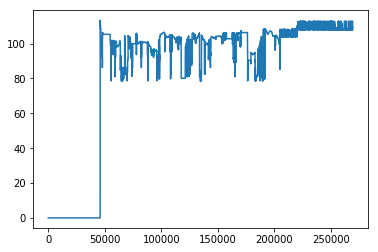

In [1147]:
plt.plot(A.real_freq)
print(len(A.real_freq))
64504*8

In [1170]:
def build_output(self):
    output = np.zeros_like(self.wav)
    
    #desired = (np.linspace(200,75,len(output),endpoint=True))
    #desired = (np.rint(np.linspace(0,7,len(output),endpoint=True))*20)+70
    desired = np.ones_like(self.wav)*135
    #desired = (5*np.sin(2*np.pi*(10)*np.arange(len(self.wav))/44100))+130
    #desired = (np.arange(len(output))//1000)*20+80
    i_pnt = 21000
    o_pnt = 21000

    while i_pnt < (len(desired)-500) and o_pnt < (len(desired)-500):
        
        cur_freq = self.real_freq[i_pnt]
        des_freq = desired[o_pnt]
        
        if cur_freq < 70 or cur_freq > 5000:
            output[o_pnt:o_pnt+100] = self.wav[i_pnt:i_pnt+100]
            i_pnt += 100
            o_pnt += 100
            continue
    
        i_sz = int(np.rint(44100/cur_freq))
        o_sz = int(np.rint(i_sz*(cur_freq/des_freq)))
        
        #print(i_sz*cur_freq/des_freq)
        #print(o_sz)
        
        out_slice = resample(self.wav[i_pnt:i_pnt+i_sz+1], o_sz)
        #print(len(out_slice))
        output[o_pnt:o_pnt+o_sz] = out_slice

        i_pnt += int(i_sz)
        o_pnt += int(o_sz)

        if abs(i_pnt - o_pnt) > o_sz:
            if i_pnt < o_pnt:
                o_pnt -= o_sz
            if i_pnt > o_pnt:
                output[o_pnt:o_pnt+o_sz] = out_slice
                o_pnt += o_sz

    return output

In [1171]:
ot = build_output(A)
#sd.play(A.output, 44100)

In [1172]:
sd.play(ot, 44100)

In [1168]:
sd.play(A.wav, 44100)

In [1047]:
print('Orig:', len(A.wav))
print('Diff:', len(ot))

Orig: 127442
Diff: 127442


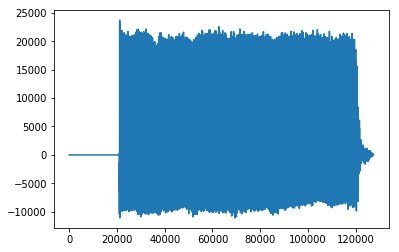

In [1048]:
plt.plot(ot)

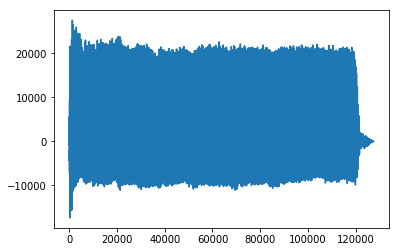

In [1049]:
plt.plot(A.wav)

In [1177]:
# indx of dwnsmpld to freq
dsf = (44100/8) #samp/sec
indx = 15 # samps
freq = 1/(indx/dsf)
freq

367.5

In [1187]:
# indx of dwnsmpld to freq
dsf = (44100) #samp/sec
indx = (110)*8 # samps
freq = 1/(indx/dsf)
freq

50.11363636363637

In [1180]:
int(123.523)

123

In [1185]:
min_freq=400
int(44100.0/(float(min_freq)*8))

13